## Мультиадронный генератор. Фит

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os.path
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylib.style as pys
import pylib.preprocess as preprocess
import pylib.fit as pyfit
import iminuit

%matplotlib inline
plt.rcParams['figure.dpi'] = 120

In [3]:
exp_tree = uproot.open(f'../trees/19/multihadrons.root')['t']
mc_tree = uproot.open(f'../trees/19/mc.root')['t']
df_exp = preprocess.read_tree(exp_tree, mc=True)
df_mc = preprocess.read_tree(mc_tree, mc=True)

In [85]:
energies_list = df_exp.index.unique().intersection(df_mc.index.unique())
for i in sorted(energies_list):
    print(i, end=' ')
it = iter(energies_list)

550.0 700.0 950.0 

In [82]:
fit_range = (-40, 20)
hist_range = (-40, 40)
width = fit_range[1] - fit_range[0]

params = {
    'n_sig': (100, (0.1, None)),
#     'n_bkg': (  10, (0, None)),    
    'm'    : (   0, (-5, 5)),
    'sL'   : (   2, (1, 10)),
    'sR'   : (   5, (1, 10)),
    'aL'   : (   0, (0, 10)),
    'aR'   : (   0, (0, 10)),
#     'k'    : ( 0.1, (0, None)),
    'y0'   : (   0, (0, None)),
    'dy'   : (   0, (0, None)),
}

In [83]:
def get_x1(df_exp, df_mc, e0):
    dfE = df_exp.loc[e0].copy()
    dfM =  df_mc.loc[e0].copy()
    assert dfM.runnum.nunique()==1
    return dfE, dfM

def get_params_exp(params, m_mc, non_limited=['n_sig', 'n_bkg', 'k']):
    params_exp = params.copy()
    for k in m_mc.parameters:
        params_exp[k] = ( m_mc.values[k], params_exp[k][1] )
        if k not in non_limited:
            mean, std = m_mc.values[k], 2*m_mc.errors[k]
            params_exp[k] = ( m_mc.values[k],(mean-std, mean+std) )
    return params_exp

In [102]:
e0 = next(it)
print(f'Energy {e0} MeV')

Energy 950.0 MeV


In [103]:
dfE, dfM = get_x1(df_exp, df_mc, e0)
dataE, dataM = dfE.x1.values, dfM.x1.values

m_mc, cost_mc = pyfit.fitter(dataM, fit_range, params.copy(), mc=True)
m_mc.simplex().migrad(iterate=20).hesse()
assert m_mc.valid

params_exp = get_params_exp(params, m_mc, ['n_sig', 'm', 'y0', 'dy'])
m_exp, cost_exp = pyfit.fitter(dataE, fit_range, params_exp, mc=False)
m_exp.limits['sR'] = (1, None)
m_exp.limits['sL'] = (1, None)
m_exp.limits['aR'] = (0, None)
m_exp.limits['aL'] = (0, None)
m_exp.simplex().migrad(iterate=20).migrad().migrad().hesse()
assert m_exp.valid

In [104]:
m_exp.simplex().migrad()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 33.48                      │              Nfcn = 805              │
│ EDM = 7.56e-11 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n_sig │    46     │     8     │            │            │   0.1   │         │       │
│ 1 │ m     │    0.1    │    1.1    │            │            │   -5    │    5    │       │
│ 2 │ sL    │    2.5    │    0.9    │            │            │    1    │         │       │
│ 3 │ sR    │    2.7    │    0.8    │            │            │    1    │         │       │
│ 4 │ aL    │   0.07    │   0.05    │            │            │    0    │         │       │
│ 5 │ aR    │   0.16    │   0.05    │            │            │    0    │         │       │
│ 6 │ y0    │   0.08    │   0.07    │            │            │    0    │         │       │
│ 7 │ dy    │   0.00    │   0.24    │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────────────────────────────────────────┐
│       │     n_sig         m        sL        sR        aL        aR        y0        dy │
├───────┼─────────────────────────────────────────────────────────────────────────────────┤
│ n_sig │      56.5    -0.177    -0.429    0.0554    0.0945    0.0313    -0.177  2.55e-13 │
│     m │    -0.177      1.15     0.768    -0.263   -0.0133 -0.000546   0.00294  3.41e-15 │
│    sL │    -0.429     0.768     0.881   -0.0766   -0.0234  0.000705   0.00715  6.35e-15 │
│    sR │    0.0554    -0.263   -0.0766     0.623   0.00168   -0.0188 -0.000924  8.42e-16 │
│    aL │    0.0945   -0.0133   -0.0234   0.00168    0.0022  0.000166  -0.00158  4.08e-16 │
│    aR │    0.0313 -0.000546  0.000705   -0.0188  0.000166   0.00238 -0.000522  1.36e-15 │
│    y0 │    -0.177   0.00294   0.00715 -0.000924  -0.00158 -0.000522   0.00436  2.58e-15 │
│    dy │  2.55e-13  3.41e-15  6.35e-15  8.42e-16  4.08e-16  1.36e-15  2.58e-15  3.61e-22 │
└───────┴─────────────────────────────────────────────────────────────────────────────────┘

In [105]:
n0 = dfE.query('(x1>=-40)&(x1<=20)').shape[0]
nsig = dfE.query('(x1>=-40)&(x1<=20)&(sim_parts=="$K_L$$K_S$")').shape[0]
print(f'Nsig = {nsig}; Nbkg = {n0-nsig}')

Nsig = 48; Nbkg = 3


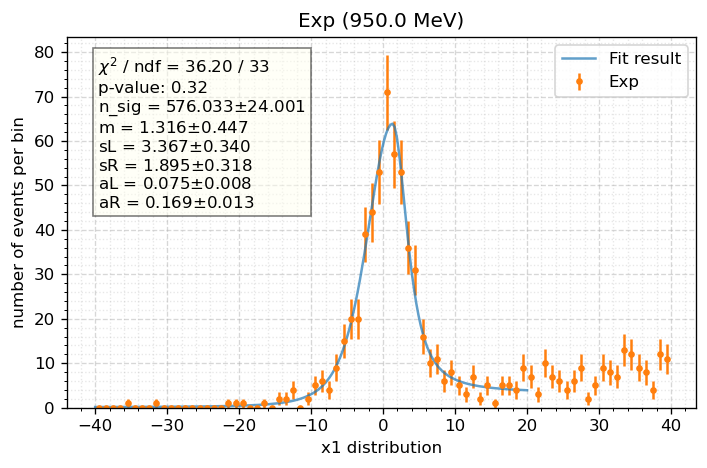

In [106]:
pys.plot_fit(dataM, cost_mc, m_mc, 80, hist_range, fit_range, errors=True, label='Exp', xtitle='x1 distribution',
               ytitle='number of events per bin', title=f'Exp ({e0} MeV)', description=True)

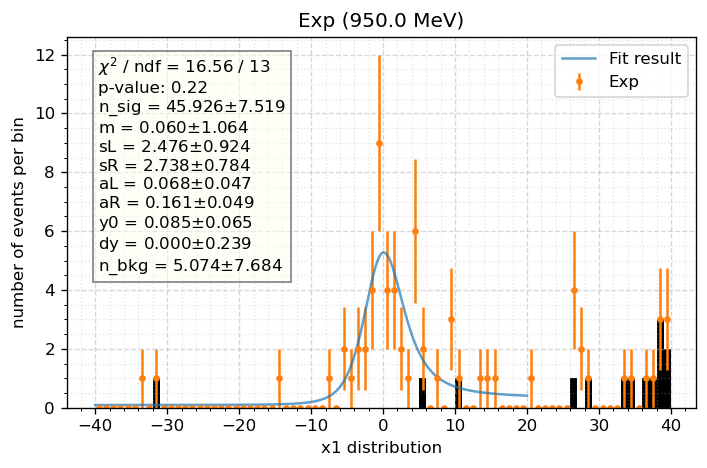

In [107]:
bins = 80
pys.plot_fit(dataE, cost_exp, m_exp, bins, hist_range, fit_range, errors=True, label='Exp', xtitle='x1 distribution',
               ytitle='number of events per bin', title=f'Exp ({e0} MeV)', description=True)
plt.hist(dfE.query("sim_parts!='$K_L$$K_S$'").x1, range=hist_range, bins=bins, color='black');